## Demand Forecasting

Data: https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data
XGBoost: https://machinelearningmastery.com/xgboost-for-regression/
LSTM Univariate Predictions using PyTorch: https://www.youtube.com/watch?v=AvKSPZ7oyVg

Predicting future sales based on past data. Predicting sales 1 year into the future. Using XGBoost as baseline, expanding to an LSTM approach.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
store = 1
item = 13

In [3]:
train_data = pd.read_csv('./demand_forecasting/train.csv')
test_data = pd.read_csv('./demand_forecasting/test.csv')
train_data, test_data

(              date  store  item  sales
 0       2013-01-01      1     1     13
 1       2013-01-02      1     1     11
 2       2013-01-03      1     1     14
 3       2013-01-04      1     1     13
 4       2013-01-05      1     1     10
 ...            ...    ...   ...    ...
 912995  2017-12-27     10    50     63
 912996  2017-12-28     10    50     59
 912997  2017-12-29     10    50     74
 912998  2017-12-30     10    50     62
 912999  2017-12-31     10    50     82
 
 [913000 rows x 4 columns],
           id        date  store  item
 0          0  2018-01-01      1     1
 1          1  2018-01-02      1     1
 2          2  2018-01-03      1     1
 3          3  2018-01-04      1     1
 4          4  2018-01-05      1     1
 ...      ...         ...    ...   ...
 44995  44995  2018-03-27     10    50
 44996  44996  2018-03-28     10    50
 44997  44997  2018-03-29     10    50
 44998  44998  2018-03-30     10    50
 44999  44999  2018-03-31     10    50
 
 [45000 rows x 4 col

In [4]:
train_data[['store', 'item', 'sales']].groupby(by=['store']).mean()

,item,sales
store,,
1,25.5,47.268379
2,25.5,67.033165
3,25.5,59.530602
4,25.5,54.902946
5,25.5,39.770164
6,25.5,39.733516
7,25.5,36.363735
8,25.5,64.142048
9,25.5,55.049025


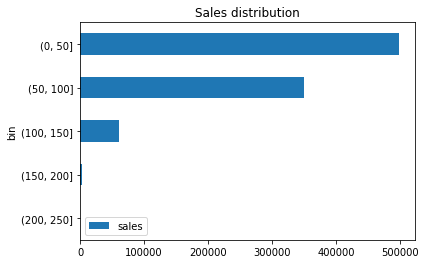

In [5]:
train_data_statistics = train_data.copy()

train_data_statistics['bin'] = pd.cut(train_data['sales'], [0, 50, 100, 150, 200, 250])
sales_bins = train_data_statistics[['bin', 'sales']].groupby(by=['bin']).count()

sales_bins.sort_values(by='sales', ascending=True).plot(kind='barh', title='Sales distribution', );

In [5]:
train = train_data[(train_data['store'] == store) & (train_data['item'] == item)][['date', 'sales']]
test = test_data[(test_data['store'] == store) & (test_data['item'] == item)][['date']]

train, test

(              date  sales
 219120  2013-01-01     37
 219121  2013-01-02     31
 219122  2013-01-03     50
 219123  2013-01-04     45
 219124  2013-01-05     49
 ...            ...    ...
 220941  2017-12-27     49
 220942  2017-12-28     68
 220943  2017-12-29     73
 220944  2017-12-30     70
 220945  2017-12-31     75
 
 [1826 rows x 2 columns],
              date
 10800  2018-01-01
 10801  2018-01-02
 10802  2018-01-03
 10803  2018-01-04
 10804  2018-01-05
 ...           ...
 10885  2018-03-27
 10886  2018-03-28
 10887  2018-03-29
 10888  2018-03-30
 10889  2018-03-31
 
 [90 rows x 1 columns])

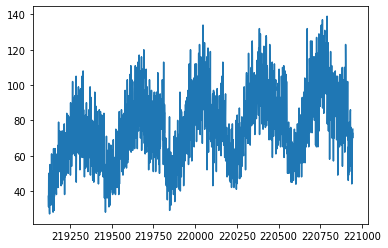

In [8]:
plt.plot(train['sales'])

In [6]:
def convert_date(data):
    data['parsed_date'] = data['date'].apply(lambda date: datetime.strptime(date, '%Y-%m-%d'))
    return data

def split_date(data):
    data['year'] = data['date'].apply(lambda date: datetime.strptime(date, '%Y-%m-%d').year)
    data['month'] = data['date'].apply(lambda date: datetime.strptime(date, '%Y-%m-%d').month)
    data['day'] = data['date'].apply(lambda date: datetime.strptime(date, '%Y-%m-%d').day)
    data['dayofweek'] = data['date'].apply(lambda date: datetime.strptime(date, '%Y-%m-%d').weekday())
    return data
    
train = split_date(train)
test = split_date(test)
train = convert_date(train)
test = convert_date(test)

train, test

(              date  sales  year  month  day  dayofweek parsed_date
 219120  2013-01-01     37  2013      1    1          1  2013-01-01
 219121  2013-01-02     31  2013      1    2          2  2013-01-02
 219122  2013-01-03     50  2013      1    3          3  2013-01-03
 219123  2013-01-04     45  2013      1    4          4  2013-01-04
 219124  2013-01-05     49  2013      1    5          5  2013-01-05
 ...            ...    ...   ...    ...  ...        ...         ...
 220941  2017-12-27     49  2017     12   27          2  2017-12-27
 220942  2017-12-28     68  2017     12   28          3  2017-12-28
 220943  2017-12-29     73  2017     12   29          4  2017-12-29
 220944  2017-12-30     70  2017     12   30          5  2017-12-30
 220945  2017-12-31     75  2017     12   31          6  2017-12-31
 
 [1826 rows x 7 columns],
              date  year  month  day  dayofweek parsed_date
 10800  2018-01-01  2018      1    1          0  2018-01-01
 10801  2018-01-02  2018      1    2

In [7]:
train = train.set_index('parsed_date')
test = test.set_index('parsed_date')

train, test

(                   date  sales  year  month  day  dayofweek
 parsed_date                                                
 2013-01-01   2013-01-01     37  2013      1    1          1
 2013-01-02   2013-01-02     31  2013      1    2          2
 2013-01-03   2013-01-03     50  2013      1    3          3
 2013-01-04   2013-01-04     45  2013      1    4          4
 2013-01-05   2013-01-05     49  2013      1    5          5
 ...                 ...    ...   ...    ...  ...        ...
 2017-12-27   2017-12-27     49  2017     12   27          2
 2017-12-28   2017-12-28     68  2017     12   28          3
 2017-12-29   2017-12-29     73  2017     12   29          4
 2017-12-30   2017-12-30     70  2017     12   30          5
 2017-12-31   2017-12-31     75  2017     12   31          6
 
 [1826 rows x 6 columns],
                    date  year  month  day  dayofweek
 parsed_date                                         
 2018-01-01   2018-01-01  2018      1    1          0
 2018-01-02   201

In [11]:
sales = train['sales'].to_dict()
train['last_year_sales'] = (train.index - pd.Timedelta('364 days')).map(sales)
test['last_year_sales'] = (test.index - pd.Timedelta('364 days')).map(sales)

train, test

(                   date  sales  year  month  day  dayofweek  last_year_sales
 parsed_date                                                                 
 2013-01-01   2013-01-01     37  2013      1    1          1              NaN
 2013-01-02   2013-01-02     31  2013      1    2          2              NaN
 2013-01-03   2013-01-03     50  2013      1    3          3              NaN
 2013-01-04   2013-01-04     45  2013      1    4          4              NaN
 2013-01-05   2013-01-05     49  2013      1    5          5              NaN
 ...                 ...    ...   ...    ...  ...        ...              ...
 2017-12-27   2017-12-27     49  2017     12   27          2             56.0
 2017-12-28   2017-12-28     68  2017     12   28          3             67.0
 2017-12-29   2017-12-29     73  2017     12   29          4             68.0
 2017-12-30   2017-12-30     70  2017     12   30          5             55.0
 2017-12-31   2017-12-31     75  2017     12   31          6    

In [143]:
training_data = train[['sales', 'year', 'month', 'day', 'dayofweek', 'last_year_sales']]
testing_data = test[['year', 'month', 'day', 'dayofweek', 'last_year_sales']]
training_data, testing_data

(             sales  year  month  day  dayofweek  last_year_sales
 parsed_date                                                     
 2013-01-01      37  2013      1    1          1              NaN
 2013-01-02      31  2013      1    2          2              NaN
 2013-01-03      50  2013      1    3          3              NaN
 2013-01-04      45  2013      1    4          4              NaN
 2013-01-05      49  2013      1    5          5              NaN
 ...            ...   ...    ...  ...        ...              ...
 2017-12-27      49  2017     12   27          2             56.0
 2017-12-28      68  2017     12   28          3             67.0
 2017-12-29      73  2017     12   29          4             68.0
 2017-12-30      70  2017     12   30          5             55.0
 2017-12-31      75  2017     12   31          6             60.0
 
 [1826 rows x 6 columns],
              year  month  day  dayofweek  last_year_sales
 parsed_date                                           

In [146]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor

X, y = training_data[['year', 'month', 'day', 'dayofweek', 'last_year_sales']].values, training_data[['sales']].values

model = XGBRegressor(n_estimators=1000, early_stopping_rounds=100)

In [147]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 8.606 (0.250)


[23:49:08] WARNING: /workspace/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:55.70034	validation_1-rmse:54.53227
[1]	validation_0-rmse:39.89840	validation_1-rmse:38.64967
[2]	validation_0-rmse:28.98500	validation_1-rmse:27.85881
[3]	validation_0-rmse:21.49566	validation_1-rmse:20.51351
[4]	validation_0-rmse:16.47522	validation_1-rmse:15.75838
[5]	validation_0-rmse:13.19544	validation_1-rmse:12.67157
[6]	validation_0-rmse:11.07080	validation_1-rmse:10.89993
[7]	validation_0-rmse:9.68457	validation_1-rmse:10.02757
[8]	validation_0-rmse:8.86317	validation_1-rmse:9.58970
[9]	validation_0-rmse:8.30976	validation_1-rmse:9.39409
[10]	validation_0-rmse:7.94096	validation_1-r

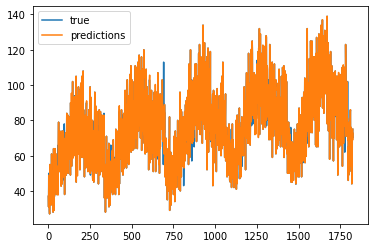

MAE on test: 8.027, RMSE on test: 10.134)


In [149]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])
predictions = model.predict(X)

plt.plot(y, label='true')
plt.plot(predictions, label='predictions')
plt.legend(loc='best')
plt.show()

y_pred = model.predict(X_test)
mae_error = mean_absolute_error(y_test, y_pred)
rmse_error = np.sqrt(mean_squared_error(y_test, y_pred))

print('MAE on test: %.3f, RMSE on test: %.3f' % (mae_error, rmse_error))

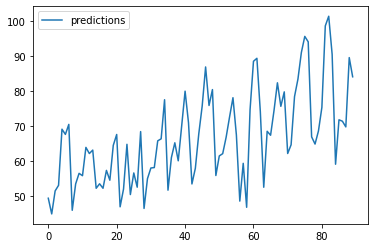

In [150]:
X_testing = testing_data[['year', 'month', 'day', 'dayofweek', 'last_year_sales']].values

y_predictions = model.predict(X_testing)

plt.plot(y_predictions, label='predictions')
plt.legend(loc='best')
plt.show()

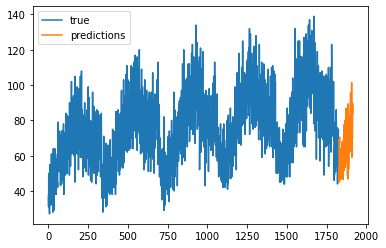

In [151]:
plt.plot(y, label='true')
plt.plot(range(len(y)+len(y_predictions)), y_predictions.reshape(-1, 1), label='predictions')
plt.legend(loc='best')
plt.show()

In [156]:
{ 'f' + str(index): value for index, value in enumerate(['year', 'month', 'day', 'dayofweek', 'last_year_sales']) }

{'f0': 'year',
 'f1': 'month',
 'f2': 'day',
 'f3': 'dayofweek',
 'f4': 'last_year_sales'}

In [168]:
feature_map = { 'f' + str(index): value for index, value in enumerate(['year', 'month', 'day', 'dayofweek', 'last_year_sales']) }
weights = model.get_booster().get_score(importance_type='weight')
weights = pd.DataFrame.from_dict({ feature_map[key]: value for key, value in weights.items() }, orient='index', columns=['weight'])

weights.sort_values(by=['weight'], ascending=False)

,weight
day,13845.0
last_year_sales,10238.0
month,9666.0
dayofweek,6588.0
year,5524.0


In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

values = train[['sales']].values

scaler.fit(values)

train['normalized_sales'] = scaler.transform(train[['sales']])

train

,date,sales,year,month,day,dayofweek,normalized_sales
parsed_date,,,,,,,
2013-01-01,2013-01-01,37,2013,1,1,1,0.089286
2013-01-02,2013-01-02,31,2013,1,2,2,0.035714
2013-01-03,2013-01-03,50,2013,1,3,3,0.205357
2013-01-04,2013-01-04,45,2013,1,4,4,0.160714
2013-01-05,2013-01-05,49,2013,1,5,5,0.196429
...,...,...,...,...,...,...,...
2017-12-27,2017-12-27,49,2017,12,27,2,0.196429
2017-12-28,2017-12-28,68,2017,12,28,3,0.366071
2017-12-29,2017-12-29,73,2017,12,29,4,0.410714


In [82]:
normalized_sales = train['normalized_sales'].to_dict()
train['sales_1'] = (train.index - pd.Timedelta('365 days')).map(normalized_sales)
train['sales_2'] = (train.index - pd.Timedelta('366 days')).map(normalized_sales)
train['sales_3'] = (train.index - pd.Timedelta('367 days')).map(normalized_sales)
train['sales_4'] = (train.index - pd.Timedelta('368 days')).map(normalized_sales)
train['sales_5'] = (train.index - pd.Timedelta('369 days')).map(normalized_sales)
train['sales_6'] = (train.index - pd.Timedelta('370 days')).map(normalized_sales)
train['sales_7'] = (train.index - pd.Timedelta('371 days')).map(normalized_sales)
test['sales_1'] = (test.index - pd.Timedelta('365 days')).map(normalized_sales)
test['sales_2'] = (test.index - pd.Timedelta('366 days')).map(normalized_sales)
test['sales_3'] = (test.index - pd.Timedelta('367 days')).map(normalized_sales)
test['sales_4'] = (test.index - pd.Timedelta('368 days')).map(normalized_sales)
test['sales_5'] = (test.index - pd.Timedelta('369 days')).map(normalized_sales)
test['sales_6'] = (test.index - pd.Timedelta('370 days')).map(normalized_sales)
test['sales_7'] = (test.index - pd.Timedelta('371 days')).map(normalized_sales)

train = train.dropna()
test = test.dropna()

train, test

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

(                   date  sales  year  month  day  dayofweek  normalized_sales  \
 parsed_date                                                                     
 2015-01-13   2015-01-13     48  2015      1   13          1          0.187500   
 2015-01-14   2015-01-14     52  2015      1   14          2          0.223214   
 2015-01-15   2015-01-15     45  2015      1   15          3          0.160714   
 2015-01-16   2015-01-16     44  2015      1   16          4          0.151786   
 2015-01-17   2015-01-17     59  2015      1   17          5          0.285714   
 ...                 ...    ...   ...    ...  ...        ...               ...   
 2017-12-27   2017-12-27     49  2017     12   27          2          0.196429   
 2017-12-28   2017-12-28     68  2017     12   28          3          0.366071   
 2017-12-29   2017-12-29     73  2017     12   29          4          0.410714   
 2017-12-30   2017-12-30     70  2017     12   30          5          0.383929   
 2017-12-31   20

In [105]:
train_X = train[['sales_7', 'sales_6', 'sales_5', 'sales_4', 'sales_3', 'sales_2', 'sales_1']].values
test_X = test[['sales_7', 'sales_6', 'sales_5', 'sales_4', 'sales_3', 'sales_2', 'sales_1']].values
train_y = train[['normalized_sales']].values

train_X.shape, test_X.shape, train_y.shape

((1084, 7), (90, 7), (1084, 1))

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [106]:
training_tensors = np.concatenate((train_X, train_y), axis=1)

train_tensors, val_tensors = train_test_split(training_tensors, test_size=0.1, shuffle=True)

training_tensors = torch.from_numpy(training_tensors).float()
train_tensors = torch.from_numpy(train_tensors).float()
val_tensors = torch.from_numpy(val_tensors).float()
test_X = torch.from_numpy(test_X).float()

training_tensors.shape, train_tensors.shape, val_tensors.shape, test_X.shape

(torch.Size([1084, 8]),
 torch.Size([975, 8]),
 torch.Size([109, 8]),
 torch.Size([90, 7]))

In [71]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

device

device(type='cuda')

In [113]:
class LSTMRegressor(nn.Module):
    def __init__(self):
        super(LSTMRegressor, self).__init__()
        
        self.lstm1 = nn.LSTMCell(1, 64)
        self.lstm2 = nn.LSTMCell(64, 64)
        self.regressor = nn.Sequential(
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 8),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(8, 1)
        )
    
    def forward(self, x):
        hidden_state_1 = torch.zeros((x.shape[0], 64), dtype=torch.float32).to(device)
        cell_state_1 = torch.zeros((x.shape[0], 64), dtype=torch.float32).to(device)
        hidden_state_2 = torch.zeros((x.shape[0], 64), dtype=torch.float32).to(device)
        cell_state_2 = torch.zeros((x.shape[0], 64), dtype=torch.float32).to(device)
        
        for input in torch.split(x, 1, dim=1):
            hidden_state_1, cell_state_1 = self.lstm1(input, (hidden_state_1, cell_state_1))
            hidden_state_2, cell_state_2 = self.lstm2(hidden_state_1, (hidden_state_2, cell_state_2))
        outputs = self.regressor(hidden_state_2)
        
        return outputs
    
model = LSTMRegressor().to(device)

In [114]:
optimizer = optim.Adam(model.parameters(), lr=0.0005)
loss_function = nn.MSELoss()

losses = []
validation_losses = []

for epoch in range(20):
    print('Epoch:', epoch+1)
    epoch_losses = []
    model.train()
    for batch in torch.split(train_tensors, 8, dim=0):
        x = batch[:, :-1].to(device)
        y = batch[:, -1:].to(device)
    
        model.zero_grad()
        outputs = model(x)
        
        loss = loss_function(outputs, y)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    print('Mean Loss:', np.mean(epoch_losses))
    losses.append(np.mean(epoch_losses))
    
    model.eval()
    with torch.no_grad():
        x = val_tensors[:, :-1].to(device)
        y = val_tensors[:, -1:].to(device)
        outputs = model(x)
        loss = loss_function(outputs, y)
    print('Validation Loss:', loss.item())
    validation_losses.append(loss.item())

Epoch: 1
Mean Loss: 0.050219227430090066
Validation Loss: 0.030006468296051025
Epoch: 2
Mean Loss: 0.029859142820732515
Validation Loss: 0.018781688064336777
Epoch: 3
Mean Loss: 0.02013946263898225
Validation Loss: 0.01311436202377081
Epoch: 4
Mean Loss: 0.019042232862032462
Validation Loss: 0.0124587407335639
Epoch: 5
Mean Loss: 0.017765009100167234
Validation Loss: 0.011919857002794743
Epoch: 6
Mean Loss: 0.017147592353810113
Validation Loss: 0.011808399111032486
Epoch: 7
Mean Loss: 0.017115817271692098
Validation Loss: 0.011956018395721912
Epoch: 8
Mean Loss: 0.017416901193696578
Validation Loss: 0.01223753485828638
Epoch: 9
Mean Loss: 0.01606679721697249
Validation Loss: 0.012116367928683758
Epoch: 10
Mean Loss: 0.016775255288058497
Validation Loss: 0.011731388978660107
Epoch: 11
Mean Loss: 0.016222853255534513
Validation Loss: 0.011734320782124996
Epoch: 12
Mean Loss: 0.015246572738253802
Validation Loss: 0.01183369755744934
Epoch: 13
Mean Loss: 0.01570240415625091
Validation Loss

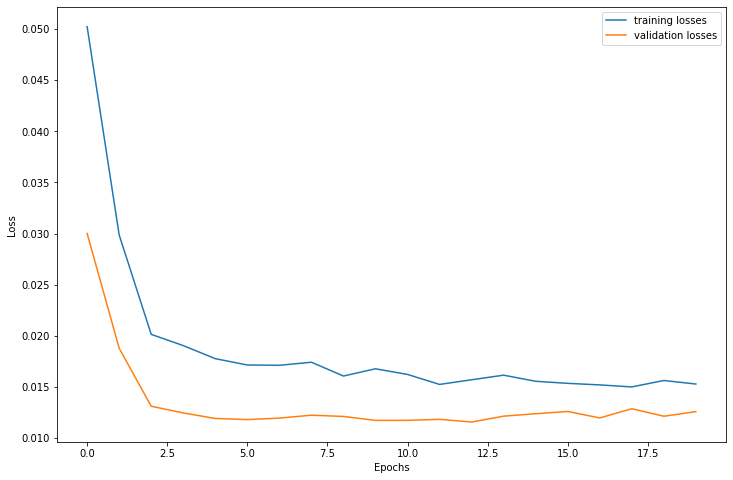

In [125]:
plt.figure(figsize=(12, 8))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(losses, label='training losses')
plt.plot(validation_losses, label='validation losses')
plt.legend(loc='best')
plt.show()

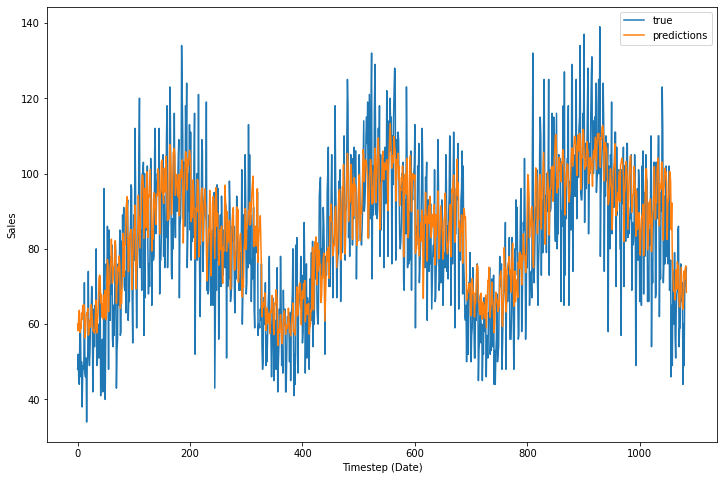

In [126]:
model.eval()
x = training_tensors[:, :-1].to(device)
y_true = scaler.inverse_transform(training_tensors[:, -1:])
with torch.no_grad():
    y_pred = scaler.inverse_transform(model(x).detach().cpu().numpy())

plt.figure(figsize=(12, 8))
plt.xlabel('Timestep (Date)')
plt.ylabel('Sales')
plt.plot(y_true, label='true')
plt.plot(y_pred, label='predictions')
plt.legend(loc='best')
plt.show()

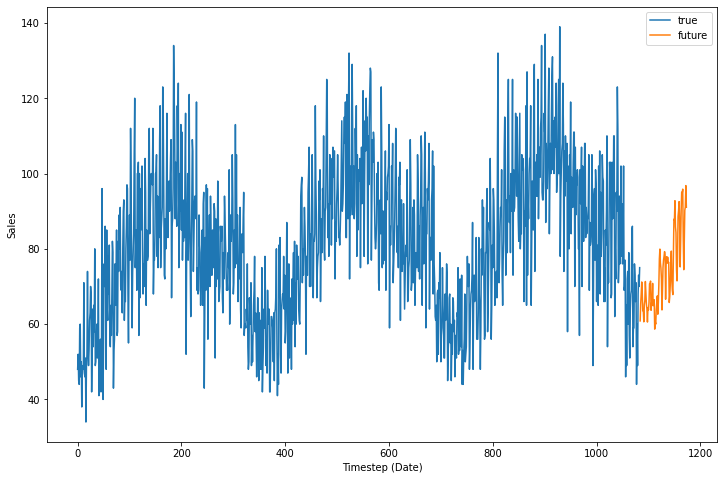

In [127]:
model.eval()
x = test_X.to(device)
y_real = scaler.inverse_transform(training_tensors[:, -1:])
with torch.no_grad():
    y_future = scaler.inverse_transform(model(x).detach().cpu().numpy())

plt.figure(figsize=(12, 8))
plt.xlabel('Timestep (Date)')
plt.ylabel('Sales')
plt.plot(y_real, label='true')
plt.plot(range(len(y_real), len(y_real)+len(y_future)), y_future, label='future')
plt.legend(loc='best')
plt.show()

In [118]:
torch.save(model, 'lstmregressor.bin')